# Parts-of-Speech Tagging

### Authors:
* Niv Harmelech, 200327864
* Ben Eyal, 301841953

# 0 Imports

In [4]:
%matplotlib inline

import itertools
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import random

from collections import Counter, defaultdict
from operator import itemgetter
from scipy.sparse import coo_matrix
from scipy.stats import entropy

## 1 Data Exploration

### 1.1 Manual Tagging

* One/NUM
of/ADP
the/DET
most/ADJ
basic/ADJ
and/CONJ
most/ADJ
useful/ADJ
tasks/NOUN
when/ADV
processing/VERB
text/NOUN
is/VERB
to/PART
tokenize/VERB
each/DET
word/NOUN
separately/ADV
and/CONJ
label/VERB
each/DET
word/NOUN
according/ADP
to/ADP
its/ADJ
most/ADJ
likely/ADJ
part/NOUN
of/ADP
speech/NOUN
./PUNCT

* In/ADP
the/DET
mid/NOUN
1980s/NUM
,/PUNCT
researchers/NOUN
in/ADP
Europe/PROPN
began/VERB
to/ADP
use/VERB
hidden/ADJ
Markov/PROPN
models/NOUN
(/PUNCT
HMMs/NOUN
)/PUNCT
to/ADP
disambiguate/VERB
parts/NOUN
of/ADP
speech/NOUN
,/PUNCT
when/ADV
working/VERB
to/ADP
tag/VERB
the/DET
Lancaster/PROPN
-/PUNCT
Oslo/PROPN
-/PUNCT
Bergen/PROPN
Corpus/NOUN
of/ADP
British/ADJ
English/PROPN
./PUNCT

* A/DET
first/ADJ
approximation/NOUN
was/AUX
done/VERB
with/ADP
a/DET
program/NOUN
by/ADP
Greene/PROPN
and/CONJ
Rubin/PROPN
,/PUNCT
which/PRON
consisted/VERB
of/ADP
a/DET
huge/ADJ
handmade/ADJ
list/NOUN
of/ADP
what/ADJ
categories/NOUN
could/VERB
co-occur/VERB
at/ADV
all/ADV
./PUNCT

In the above sentences, some phrases are harder to tag manually, due to tokenization.

For example, the phrase "at all" should be tagged as an adverb, but tokenizing the phrase as two separate words would cause "at" to be tagged as an adposition, and "all" as an adverb.

Another example has to do with hyphenation: it makes sense to tokenize Lancaster-Oslo-Bergen as "Lancaster", "-", "Oslo", "-", and "Bergen", as we did, and tag them accordingly. This rationale leads to tokenizing "co-occur" as "co", "-", and "occur", which might lead to incorrect tagging. We chose to treat "co-occur" as a single word, and tag it as a verb.

### 1.2 Gathering and Cleaning Up Data

In [ ]:
from google3 import AnalyzeResults, google

results = google("The Oven of Akhnai")
AnalyzeResults(results)

Since Ben enjoys these kind of things, we ran a search on "The Oven of Akhnai". `Data/Raw-0.txt` has more than enough sentences to work with, so this is exactly what we're going to do, but first, let's define ourselves a tagger.

In [84]:
brown_tagged_sents = nltk.corpus.brown.tagged_sents(tagset='universal')

size = int(0.9 * len(brown_tagged_sents))
train_sents = brown_tagged_sents[:size]
test_sents = brown_tagged_sents[size:]

re_tagger = nltk.RegexpTagger([(r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),
                               (r'(The|the|A|a|An|an)$', 'DET'),
                               (r'.*able$', 'ADJ'),
                               (r'.*ness$', 'NOUN'),
                               (r'.*ly$', 'ADV'),
                               (r'.*s$', 'NOUN'),
                               (r'.*ing$', 'VERB'),
                               (r'.*ed$', 'VERB'),
                               (r'.*', 'NOUN')])
affix_tagger = nltk.AffixTagger(train_sents, backoff=re_tagger)
unigram_tagger = nltk.UnigramTagger(train_sents, backoff=affix_tagger)
best_tagger_from_class = nltk.BigramTagger(train_sents, backoff=unigram_tagger)

print('Tagger achieves %.1f%% accuracy.' % (100 * best_tagger_from_class.evaluate(test_sents)))

Tagger achieves 95.1% accuracy.


In [ ]:
with open('Data/Raw-0.txt', encoding='utf-8') as raw:
    sents = nltk.sent_tokenize(raw.read())[:20]

with open('clean/clean', 'w', encoding='utf-8') as clean:
    for sent in sents:
        print(sent, file=clean)

with open('tagged/tagged', 'w', encoding='utf-8') as tagged:
    for sent in sents:
        print(*[nltk.tuple2str(t) for t in best_tagger_from_class.tag(nltk.word_tokenize(sent))], file=tagged)

### 1.2 Gathering Basic Statistics

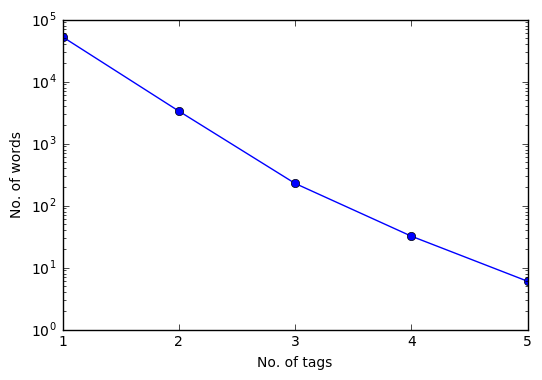

In [3]:
def plot_number_of_tags(corpus):
    words_to_tags = defaultdict(set)
    for word, tag in corpus:
        words_to_tags[word].add(tag)
    c = Counter([len(ts) for ts in words_to_tags.values()])
    x, y = zip(*c.items())
    plt.xlabel('No. of tags')
    plt.ylabel('No. of words')
    plt.xticks(np.arange(1, max(x) + 1))
    plt.semilogy(x, y, 'bo-')

plot_number_of_tags(nltk.corpus.brown.tagged_words(tagset='universal'))

# 2 Stratified Test/Train Sets

In [2]:
def stratified_split(categorized_corpus, train_size=0.9):
    train, test = [], []
    for c in categorized_corpus.categories():
        sents = categorized_corpus.tagged_sents(categories=c, tagset='universal')
        number_of_train_sents = int(len(sents) * train_size)
        train.extend(sents[:number_of_train_sents])
        test.extend(sents[number_of_train_sents:])
    random.shuffle(train)
    return train, test

# 3 Unigram

## 3.1 Unigram Tagger

### 3.1.1

In [6]:
class SimpleUnigramTagger(nltk.TaggerI):
    def __init__(self, train):
        self._cfd = nltk.ConditionalFreqDist([word for sent in train for word in sent])

    def tag(self, tokens):
        def maybe_tag(token):
            fd = self._cfd[token]
            if fd.N() > 0:
                return fd.max()
            return None
        return [(t, maybe_tag(t)) for t in tokens]

### 3.1.2

In [7]:
train_size = 0.9
train, test = stratified_split(nltk.corpus.brown, train_size=train_size)
sut = SimpleUnigramTagger(train)
ut = nltk.UnigramTagger(train)
print('SimpleUnigramTagger achieves accuracy of %.1f%%' % (100 * sut.evaluate(test)))
print('nltk.UnigramTagger achieves accuracy of %.1f%%' % (100 * ut.evaluate(test)))

SimpleUnigramTagger achieves accuracy of 91.4%
nltk.UnigramTagger achieves accuracy of 91.4%


### 3.1.3+4

In [66]:
unknown_words = 0
unknown_words_per_category = defaultdict(int)
wrong_tag = 0
for c in nltk.corpus.brown.categories():
    sents = nltk.corpus.brown.tagged_sents(categories=c, tagset='universal')
    number_of_train_sents = int(len(sents) * train_size)
    for gold_sent in sents[number_of_train_sents:]:
        tagged_sent = sut.tag(nltk.untag(gold_sent))
        for (_, tag), (_, gold) in zip(tagged_sent, gold_sent):
            if tag is None:
                unknown_words += 1
                unknown_words_per_category[c] += 1
            elif tag != gold:
                wrong_tag += 1

print('=======')
print('Errors:')
print('=======')
print('Total unknown words:', unknown_words)
for c, n in unknown_words_per_category.items():
    print('    ├ "%s": %d' % (c, n))
print('Wrong tag of known word:' ,wrong_tag)

Errors:
Total unknown words: 4849
    ├ "humor": 172
    ├ "romance": 191
    ├ "editorial": 244
    ├ "learned": 943
    ├ "adventure": 364
    ├ "lore": 393
    ├ "belles_lettres": 793
    ├ "hobbies": 435
    ├ "fiction": 228
    ├ "religion": 70
    ├ "government": 233
    ├ "reviews": 219
    ├ "mystery": 146
    ├ "news": 392
    ├ "science_fiction": 26
Wrong tag of known word: 5368


## 3.2 Using Entropy to Filter Affix Tagger

In [9]:
class SuffixTagger(nltk.AffixTagger):
    def __init__(self, train=None, model=None, suffix_length=3, entropy_cutoff=None, **kwargs):
        self._entropy_cutoff = entropy_cutoff
        super(SuffixTagger, self).__init__(train, model, affix_length=-suffix_length, **kwargs)
    
    def _train(self, tagged_corpus, cutoff=0, verbose=False):
        token_count = hit_count = 0

        useful_contexts = set()

        cfd = nltk.ConditionalFreqDist()
        for sentence in tagged_corpus:
            tokens, tags = zip(*sentence)
            for index, (token, tag) in enumerate(sentence):
                token_count += 1
                context = self.context(tokens, index, tags[:index])
                if context is None:
                    continue
                cfd[context][tag] += 1
                if (self.backoff is None or tag != self.backoff.tag_one(tokens, index, tags[:index])):
                    useful_contexts.add(context)

        for context in useful_contexts:
            fd = cfd[context]
            e = entropy([fd.freq(tag) for tag in fd], base=2)
            if self._entropy_cutoff is None or e < self._entropy_cutoff:
                best_tag = fd.max()
                hits = fd[best_tag]
                if hits > cutoff:
                    self._context_to_tag[context] = best_tag
                    hit_count += hits

        if verbose:
            size = len(self._context_to_tag)
            backoff = 100 - (hit_count * 100.0)/ token_count
            pruning = 100 - (size * 100.0) / len(cfd.conditions())
            print("[Trained Unigram tagger:", end=' ')
            print("size=%d, backoff=%.2f%%, pruning=%.2f%%]" % (size, backoff, pruning))

To see if filtering has any noticeable effect, we'll use a UnigramTagger.

In [194]:
ut = nltk.UnigramTagger(train=train)
print('UnigramTagger achieves an accuracy of %.1f%%' % (100 * unigram_tagger.evaluate(test),))

UnigramTagger achieves an accuracy of 95.6%


Without backoff or cutoff, the suffix tagger performs very poorly.

In [115]:
st = SuffixTagger(train=train)
print('SuffixTagger achieves an accuracy of %.1f%%' % (100 * st.evaluate(test),))

SuffixTagger achieves an accuracy of 29.7%


Let's see what happens when we use our RegEx tagger as a backoff:

In [195]:
st = SuffixTagger(train=train, backoff=ut)
print('SuffixTagger w/backoff achieves an accuracy of %.1f%%' % (100 * st.evaluate(test),))

SuffixTagger w/backoff achieves an accuracy of 88.1%


So we can see that "the whole is greater than the sum of its parts" - combining the suffix tagger with the RegEx tagger as backoff gave a better result than using any of the taggers separately.

Now let's find an optimal value for the entropy cutoff. The upper-bound for $H\left(X\right)$ is $\log n$, $n$ being the number of tags in the distribution, and the equality holds only when all probabilities are equal. In a previous question, we've shown that a word has, at most, 5 tags. In general, there are 12 tags in the corpus, but that would be overkill.

The optimal cutoff parameter is 0.4804, achieving accuracy of 93.48%.


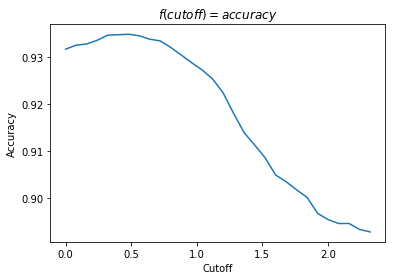

In [10]:
def optimize_parameter(train):
    new_train_size = int(0.9 * len(train))
    new_train, dev = train[:new_train_size], train[new_train_size:]
    unigram_tagger = nltk.UnigramTagger(train=new_train)

    max_accuracy, max_c = 0, 0
    accuracies = []
    cutoff_range = np.linspace(0, np.log2(5), num=30)
    for c in cutoff_range:
        st = SuffixTagger(train=new_train, backoff=unigram_tagger, entropy_cutoff=c)
        accuracy = st.evaluate(dev)
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            max_c = c
    plt.title('$f(cutoff) = accuracy$')
    plt.xlabel('Cutoff')
    plt.ylabel('Accuracy')
    plt.plot(cutoff_range, accuracies)
    return max_c, max_accuracy

cutoff, accuracy = optimize_parameter(train)
print('The optimal cutoff parameter is %.4f, achieving accuracy of %.2f%%.' % (cutoff, 100 * accuracy))

# 4 Fine-Grained Accuracy and Error Analysis

## 4.1 Per Tag Precision and Recall

### 4.1.1

In [72]:
def micro_evaluate(self, corpus_test):
    tagged_sents = self.tag_sents(nltk.tag.util.untag(sent) for sent in corpus_test)
    gold_tokens = set(sum(corpus_test, []))
    test_tokens = set(sum(tagged_sents, []))
    tags = set(tag for _, tag in gold_tokens)
    stats_per_tag = {}
    for tag in tags:
        test_tokens_for_tag = set(w for w, t in test_tokens if t == tag)
        test_tokens_for_not_tag = set(w for w, t in test_tokens if t != tag)
        gold_tokens_for_tag = set(w for w, t in gold_tokens if t == tag)
        gold_tokens_for_not_tag = set(w for w, t in gold_tokens if t != tag)
        tp = len(test_tokens_for_tag & gold_tokens_for_tag)
        tn = len(test_tokens_for_not_tag & gold_tokens_for_not_tag)
        fp = len(test_tokens_for_tag & gold_tokens_for_not_tag)
        fn = len(gold_tokens_for_tag & test_tokens_for_not_tag)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f = 2 * precision * recall / (precision + recall)
        stats_per_tag[tag] = {'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
                              'Precision': precision, 'Recall': recall, 'F-Measure': f}
    df = pd.DataFrame(stats_per_tag).sort_values('F-Measure', axis=1).T
    df[['TP', 'TN', 'FP', 'FN']] = df[['TP', 'TN', 'FP', 'FN']].astype(int)
    return df[['TP', 'TN', 'FP', 'FN', 'Precision', 'Recall','F-Measure']]
    

setattr(nltk.tag.TaggerI, 'micro_evaluate', micro_evaluate)

tagged_sents = nltk.corpus.brown.tagged_sents(tagset='universal')
tagger = nltk.UnigramTagger(train)
tagger.micro_evaluate(test)

,TP,TN,FP,FN,Precision,Recall,F-Measure
X,23,14889,11,143,0.676471,0.138554,0.230000
PRT,75,14946,15,45,0.833333,0.625000,0.714286
ADP,116,14923,42,29,0.734177,0.800000,0.765677
ADJ,1670,12734,215,690,0.885942,0.707627,0.786808
NUM,225,14703,6,113,0.974026,0.665680,0.790861
NOUN,5793,7034,482,2349,0.923187,0.711496,0.803635
CONJ,16,15028,6,1,0.727273,0.941176,0.820513
VERB,2785,11578,263,908,0.913714,0.754129,0.826287
ADV,624,14323,50,185,0.925816,0.771323,0.841537
DET,49,14994,9,5,0.844828,0.907407,0.875000


### 4.1.2

Not very surprising to see **X** as the hardest tag to give correctly, and by a *huge* margin. There aren't many positive examples of **X**, only 166, and our simple `UnigramTagger` managed to correctly tag only 23 of them. When the tagger "took a chance" and tagged a word as **X**, it got the right tag only about two-thirds of the time.

Linguistically, it is expected that **X** would be difficult, since it has no defining characteristics, other than "looks like a cat took a stroll on a keyboard". Yes, it also contains foreign words, but for a pretty dumb English speaker (our tagger, for instance), foreign words might as well be the musings of a cat.

## 4.2 Confusion Matrix

### 4.2.1

In [73]:
def confusion_matrix(self, corpus_test):
    tagged_sents = self.tag_sents(nltk.tag.util.untag(sent) for sent in corpus_test)
    y_true = np.array([tag for _, tag in sum(corpus_test, [])])
    y_pred = np.array([tag for _, tag in sum(tagged_sents, [])])

    labels = np.array(list(sorted(set(y_true) | set(y_pred))))

    sample_weight = np.ones(y_true.shape[0], dtype=np.int)

    n_labels = labels.size
    label_to_ind = dict((y, x) for x, y in enumerate(labels))
    y_pred = np.array([label_to_ind.get(x, n_labels + 1) for x in y_pred])
    y_true = np.array([label_to_ind.get(x, n_labels + 1) for x in y_true])
    ind = np.logical_and(y_pred < n_labels, y_true < n_labels)
    y_pred = y_pred[ind]
    y_true = y_true[ind]
    sample_weight = sample_weight[ind]

    CM = coo_matrix((sample_weight, (y_true, y_pred)), shape=(n_labels, n_labels)).toarray()

    return CM, labels

setattr(nltk.tag.TaggerI, 'confusion_matrix', confusion_matrix)

tagged_sents = nltk.corpus.brown.tagged_sents(tagset='universal')

### 4.2.2

In [74]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Obviously, the confusion matrix for `DefaultTagger` is, well, not very confusing.
The confusion matrix is a $\mathrm{True} \times \mathrm{Predicted}$ matrix, and we always predict the same tag, so only one column has positive values, while the rest are zeros. This also makes a very contrived way of counting the appearances of a specific tag: the only non-zero number on the diagonal.

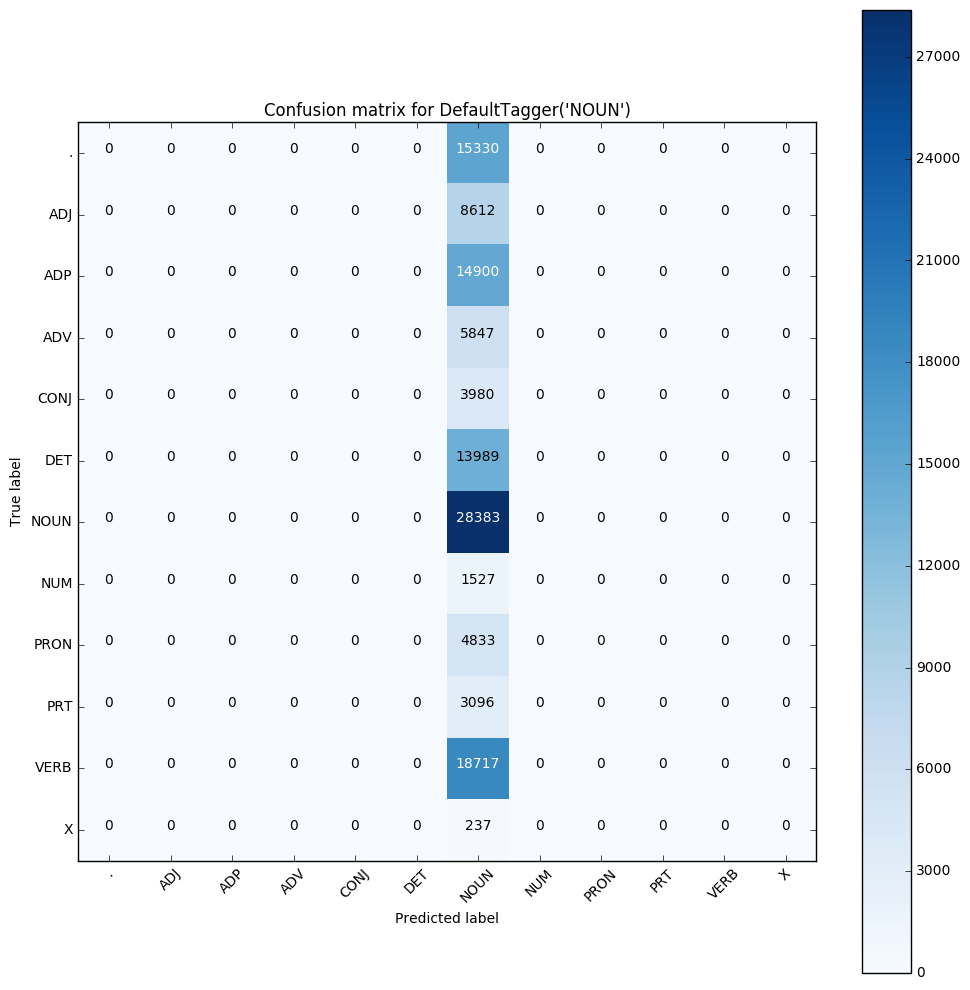

In [75]:
tagger = nltk.DefaultTagger('NOUN')
cm, labels = tagger.confusion_matrix(test)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title="Confusion matrix for DefaultTagger('NOUN')")
plt.show()

### 4.2.3

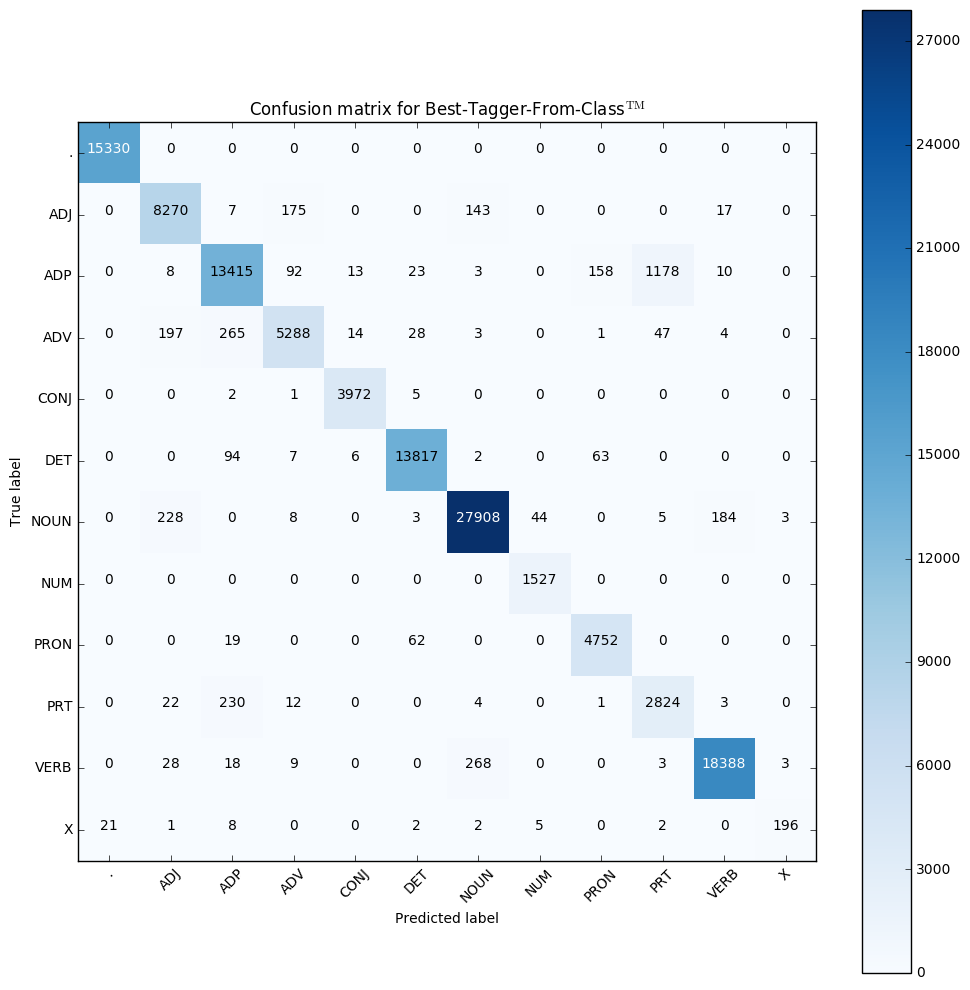

In [76]:
cm, labels = best_tagger_from_class.confusion_matrix(test)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title='Confusion matrix for Best-Tagger-From-Class$^\mathrm{TM}$')
plt.show()

# 5 Averaged Perceptron

## 5.1

The Averaged Perceptron algorithm works almost like a regular Perceptron (amazing, we know): for each training example, we try to predict the tag according to the given features, and we higher or lower the weights, depending if the prediction was correct or not. The problem here is that wrong predictions toward the end of training set will affect the weights more than earlier examples. To rectify this, we simply return the averaged weights.

## 5.2

In [120]:
perceptron_tagger = nltk.PerceptronTagger(load=False)
perceptron_tagger.train(train)

## 5.3

In [140]:
print('PerceptronTagger achieves an accuracy of %.4f%%' % (100 * perceptron_tagger.evaluate(test)))

PerceptronTagger achieves an accuracy of 0.9752%


In [78]:
perceptron_tagger.micro_evaluate(test)

,TP,TN,FP,FN,Precision,Recall,F-Measure
X,44,14898,5,128,0.897959,0.255814,0.398190
PRT,81,14958,30,63,0.729730,0.562500,0.635294
ADP,136,14949,72,64,0.653846,0.680000,0.666667
CONJ,17,15032,8,7,0.680000,0.708333,0.693878
ADJ,2111,12717,515,482,0.803884,0.814115,0.808967
DET,53,14999,13,10,0.803030,0.841270,0.821705
ADV,743,14345,139,175,0.842404,0.809368,0.825556
VERB,3464,11672,608,676,0.850688,0.836715,0.843643
PRON,39,15005,5,8,0.886364,0.829787,0.857143
.,12,15032,3,0,0.800000,1.000000,0.888889


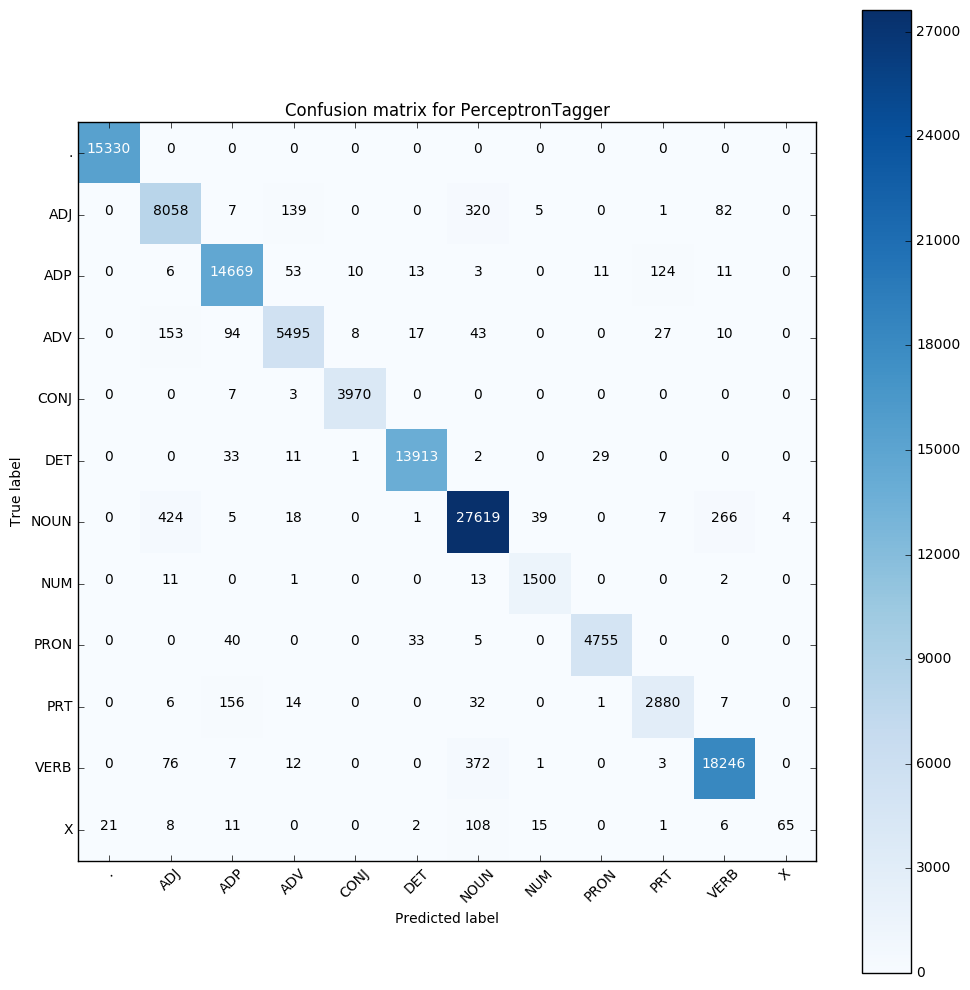

In [79]:
cm, labels = perceptron_tagger.confusion_matrix(test)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title="Confusion matrix for PerceptronTagger")
plt.show()

## 5.4

### 5.4.1

The `tagdict` data structure is supposed to save computation time by checking which tokens are "almost always" (97% of the time) tagged the same, given that the token appeared enough (20 times) in the training data.

In [131]:
print("The tagdict data structure has %d elements." % (len(perceptron_tagger.tagdict)),)

The tagdict data structure has 3667 elements.


In [134]:
tagdict_words = set(perceptron_tagger.tagdict)
count = tagdict_hits = 0
for sent in test:
    for word, _ in sent:
        if word in tagdict_words:
            tagdict_hits += 1
        count += 1
print('%d out of %d words are predicted using tagdict, which are %.2f%% of the test set.' % (tagdict_hits,
                                                                                             count,
                                                                                             100 * tagdict_hits / count))

81364 out of 119451 words are predicted using tagdict, which are 68.11% of the test set.


### 5.4.2

Oh, yes, and it's pretty funny, actually. For example, "William Tell is a hero in Swiss legend". Obviously, William Tell is a proper noun, and so we would expect William/NOUN Tell/NOUN. But surprise, surprise...

In [130]:
perceptron_tagger.tag(nltk.word_tokenize("William Tell is a hero in Swiss legend."))

[('William', 'NOUN'),
 ('Tell', 'VERB'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('hero', 'NOUN'),
 ('in', 'ADP'),
 ('Swiss', 'ADJ'),
 ('legend', 'NOUN'),
 ('.', '.')]

To this day, William doesn't know who is a hero in Swiss legend, and to whom this message was addressed.

### 5.4.3

In [137]:
class NoTagdictPerceptronTagger(nltk.TaggerI):
    START = ['-START-', '-START2-']
    END = ['-END-', '-END2-']
    
    def __init__(self):
        self.model = nltk.tag.perceptron.AveragedPerceptron()
        self.classes = set()
        self.normalize = nltk.PerceptronTagger.normalize
        self._get_features = nltk.PerceptronTagger._get_features

    def tag(self, tokens):
        prev, prev2 = self.START
        output = []
        
        context = self.START + [self.normalize(w) for w in tokens] + self.END
        for i, word in enumerate(tokens):
            features = self._get_features(i, word, context, prev, prev2)
            tag = self.model.predict(features)
            output.append((word, tag))
            prev2 = prev
            prev = tag

        return output

    def train(self, sentences, nr_iter=5):
        counts = defaultdict(lambda: defaultdict(int))
        for sentence in sentences:
            for word, tag in sentence:
                counts[word][tag] += 1
                self.classes.add(tag)
        self.model.classes = self.classes
        for iter_ in range(nr_iter):
            c = 0
            n = 0
            for sentence  in sentences:
                words = [word for word,tag in sentence]
                tags  = [tag for word,tag in sentence]
                
                prev, prev2 = self.START
                context = self.START + [self.normalize(w) for w in words] + self.END
                for i, word in enumerate(words):
                    feats = self._get_features(i, word, context, prev, prev2)
                    guess = self.model.predict(feats)
                    self.model.update(tags[i], guess, feats)
                    prev2 = prev
                    prev = guess
                    c += guess == tags[i]
                    n += 1
            random.shuffle(sentences)
        self.model.average_weights()

In [138]:
ntp = NoTagdictPerceptronTagger()
ntp.train(train)

In [141]:
print('NoTagdictPerceptronTagger achieves an accuracy of %.4f%%' % (ntp.evaluate(test)))

TagdictlessPerceptron achieves an accuracy of 0.9759%


In [142]:
ntp.micro_evaluate(test)

,TP,TN,FP,FN,Precision,Recall,F-Measure
X,41,14899,5,131,0.891304,0.238372,0.376147
PRT,86,14957,32,60,0.728814,0.589041,0.651515
ADP,137,14953,73,71,0.652381,0.658654,0.655502
CONJ,17,15033,7,7,0.708333,0.708333,0.708333
DET,53,14999,16,11,0.768116,0.828125,0.796992
ADJ,2093,12749,472,507,0.815984,0.805000,0.810455
ADV,739,14346,135,172,0.845538,0.811196,0.828011
VERB,3498,11668,639,678,0.845540,0.837644,0.841573
PRON,41,15005,5,6,0.891304,0.872340,0.881720
.,12,15032,3,0,0.800000,1.000000,0.888889


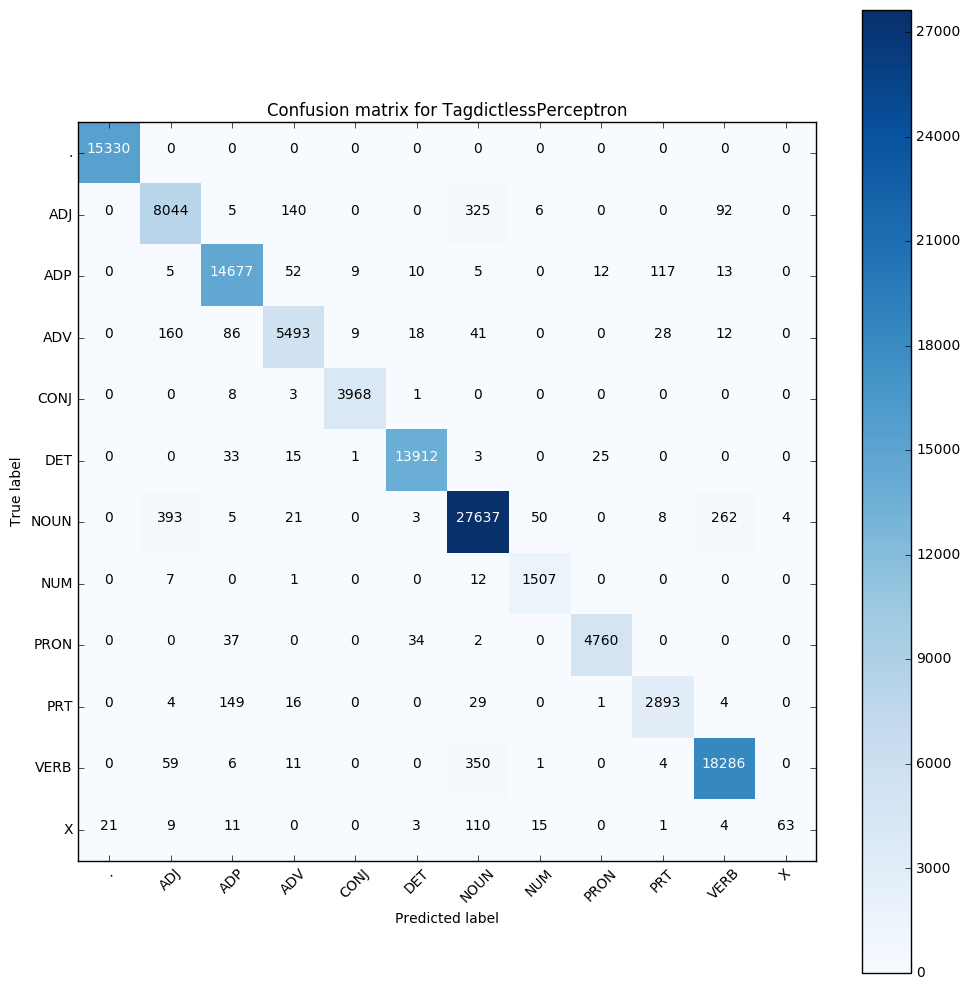

In [143]:
cm, labels = ntp.confusion_matrix(test)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title="Confusion matrix for NoTagdictPerceptronTagger")
plt.show()

The results are almost the same, with `NoTagdictPerceptronTagger` managing to be 0.0007% more accurate than `PerceptronTagger`. But here's something interesting: remember William Tell?

In [144]:
ntp.tag(nltk.word_tokenize("William Tell is a hero in Swiss legend."))

[('William', 'NOUN'),
 ('Tell', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('hero', 'NOUN'),
 ('in', 'ADP'),
 ('Swiss', 'ADJ'),
 ('legend', 'NOUN'),
 ('.', '.')]

I bet these 0.0007% came from cases like these. Since the tagdict contains tokens that were tagged with a certain tag at least 97% of the time, there are some cases that fit the "at most 3%" that are left.

### 5.4.4

In [148]:
def get_features(perceptron_tagger, tagged_sentence):
    prev, prev2 = perceptron_tagger.START
    output = []

    context = perceptron_tagger.START + [perceptron_tagger.normalize(w) for w in tagged_sentence] + perceptron_tagger.END
    for i, word in enumerate(tagged_sentence):
        tag = perceptron_tagger.tagdict.get(word)
        if not tag:
            features = perceptron_tagger._get_features(i, word, context, prev, prev2)
            tag = perceptron_tagger.model.predict(features)
            output.append(features)
        prev2 = prev
        prev = tag

    return output

In [163]:
sentence = list(zip(*test[0]))[0]
print('Features for sentence:', ' '.join(sentence))
for features in get_features(perceptron_tagger, sentence):
    for feature, value in sorted(features.items()):
        print(feature, '=', value)
    print()

Features for sentence: The rancher was trembling .
bias = 1
i pref1 r = 1
i suffix her = 1
i tag+i-2 tag DET -START- = 1
i word rancher = 1
i+1 suffix was = 1
i+1 word was = 1
i+2 word trembling = 1
i-1 suffix the = 1
i-1 tag DET = 1
i-1 tag+i word DET rancher = 1
i-1 word the = 1
i-2 tag -START- = 1
i-2 word -START2- = 1



We can see that for the sentence above, we only have one feature vector. Why is that? Well, the words "the", "was", "trembling", and "." are already covered by the tagdict, so no features are collected on them.

Here's an explanation regarding each of the collected features, excluding the constant bias:

| **Feature**          | **Description**                                                     | **Knowledge** |
|----------------------|---------------------------------------------------------------------|---------------|
| $i$ suffix           | 3-letter suffix of the current word                                 | Morphological |
| $i$ pref1            | first letter of the current word                                    | Morphological |
| $i-1$ tag            | tag of the previous word                                            | Morphological |
| $i-2$ tag            | tag of 2nd previous word                                            | Morphological |
| $i$ tag + $i-2$ tag  | tag of current word, together with the tag of the 2nd previous word | Syntactic     |
| $i$ word             | current word                                                        | Lexical       |
| $i-1$ tag + $i$ word | tag of the previous word, and the current word                      | Syntactic     |
| $i-1$ word           | previous word                                                       | Lexical       |
| $i-1$ suffix         | 3-letter suffix of the previous word                                | Morphological |
| $i-2$ word           | 2nd previous word                                                   | Lexical       |
| $i+1$ word           | next word                                                           | Lexical       |
| $i+1$ suffix         | 3-letter suffix of the next word                                    | Morphological |
| $i+2$ word           | 2nd next word                                                       | Lexical       |

### 5.4.5

The `normalize` function is responsible for transforming all tokens to a single standard:

* All words are lower-case so as to not distinguish between words in the middle of a sentence, start of a sentence, or title-cased.
* All 4-digit numbers are years, e.g. the tagging of "I was born in 1948" is the same as "I was born in 2004".
* All words beginning with a digit are numbers, e.g. "I won 5000 dollars" and "I won 5K dollars" are tagged the same.

### 5.4.6

In [166]:
print('After training, the PerceptronTagger holds weights of %d features.' % (len(perceptron_tagger.model.weights),))

After training, the PerceptronTagger holds weights of 107641 features.


Upon inspecting the weights of the tagger, we can derive some "if ... then ..." rules. Let's see some examples:

In [181]:
rules = list(perceptron_tagger.model.weights.items())
print('Feature:',
      rules[31],
      '\n"If the previous word is tagged as DET and the current word is \"longhand\", then it should be tagged NOUN."\n')
print('Feature:',
      rules[45],
      '\n"If the current word is \"bad\", then it should be tagged ADJ."\n')
print('Feature:',
      rules[68],
      '\n"If the suffix of the next word is \"tic\", then it should be tagged ADV."')

Feature: ('i-1 tag+i word DET longhand', {'ADJ': -1.745, 'NOUN': 1.991, 'X': -0.246}) 
"If the previous word is tagged as DET and the current word is "longhand", then it should be tagged NOUN."

Feature: ('i word bad', {'ADJ': 9.184, 'VERB': -2.878, 'ADV': 1.569, 'ADP': -0.973, 'NOUN': -4.984, 'X': -1.917}) 
"If the current word is "bad", then it should be tagged ADJ."

Feature: ('i+1 suffix tic', {'NUM': 1.001, 'ADJ': -3.044, 'DET': 3.523, 'CONJ': 0.228, 'VERB': -0.272, 'ADV': 6.618, 'PRON': -1.184, 'ADP': 3.93, 'NOUN': -5.508, 'PRT': -3.318, 'X': -1.973}) 
"If the suffix of the next word is "tic", then it should be tagged ADV."
